In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import dython
from matplotlib import rc
import statsmodels.formula.api as smf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from statsmodels.tools.tools import add_constant
from catboost import CatBoostRegressor, Pool
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, make_scorer
from category_encoders.cat_boost import CatBoostEncoder           # More user-friendly categorical encoding-compatibility with sklearn pipelines
from category_encoders.ordinal import OrdinalEncoder              # More user-friendly categorical encoding-compatibility with sklearn pipelines
from category_encoders.glmm import GLMMEncoder
import shap
import mc4
import os

In [2]:
from IPython.display import display, set_matplotlib_formats

In [3]:
# Set the matplotlib graphs to be exported as svg
set_matplotlib_formats('svg')

In [4]:
# Set seed for reproducility
seed_value=423
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)            # Set the `PYTHONHASHSEED` environment variable fixed
random.seed(seed_value)                                   # Set the `python` built-in pseudo-random generator fixed

---
## Median Response prediction
We try to explore the potential relationship between household-related features and the median response per household for DPR events.

In [5]:
# Load the target variable data
DPR_median_response = pd.read_csv('data/median_response_per_household.csv')
DPR_median_response.set_index('CUSTOMER_KEY', inplace=True)

# Load household filtered data
household_DPR_filtered = pd.read_csv('data/household_DPR_df.csv')
household_DPR_filtered.set_index('CUSTOMER_KEY', inplace=True)

# Inner join the datasets with the target variable
household_response = household_DPR_filtered.merge(DPR_median_response, how='inner', on='CUSTOMER_KEY')

As we have seen in the household exploration notebook the household dataset is a mixture of *categorical*, *ordinal*, and *numerical* data. Going forward we create lists of columns for each category, and convert the appropriate columns to categorical type.

In [6]:
# We drop the categorical with only one level
keep_cols = household_response.columns[household_response.nunique() > 1]
household_response = household_response[keep_cols]

In [7]:
# Numerical data
numeric_features = household_response.select_dtypes(['int64', 'float64']).columns.to_list()
# Nominal data
nominal_features = household_response.select_dtypes('object').columns.to_list()
# Ordinal data
ordinal_features = ['ASSRTD_GAS_USAGE_GROUP_CD', 'ASSRTD_ELECTRICITY_USE_GRP_CD', 'DRYER_USAGE_CD', 'REDUCING_CONSUMPTION_CD']
# Categorical data
categorical_features = list(set(nominal_features) - set(ordinal_features))

In [8]:
# Convert to category type 
#household_response[categorical_features] = household_response[categorical_features].apply(lambda x: x.astype('category'))
household_response[nominal_features] = household_response[nominal_features].apply(lambda x: x.astype('category'))

In [9]:
# Features dictionary for more informative plots
features_dict = {'HAS_GAS_COOKING': 'Use gas for cooking', 'HAS_INTERNET_ACCESS': 'Access to Internet',
                'DRYER_USAGE_CD': 'Clothes dryer usage', 'HAS_AIRCON': 'Air-conditioning',
                'NUM_REFRIGERATORS': 'Number of refrigerators', 'ASSRTD_ELECTRICITY_USE_GRP_CD': 'Assumed electricity usage',
                'REDUCING_CONSUMPTION_CD': 'Effort level', 'DWELLING_TYPE_CD': 'Dwelling type', 'HAS_POOLPUMP': 'Poolpump',
                'CONTROLLED_LOAD_CNT': 'Number of controlled load meters', 'HAS_GAS_HOT_WATER': 'Use gas for hot water',
                'ASSRTD_CLIMATE_ZONE_DESC': 'Climate zone', 'NUM_ROOMS_HEATED': 'Number of heated rooms', 
                'SERVICE_LOC_STATUS_NAME': 'Customer Service Status', 'NET_SOLAR_CNT': 'Net solar power generation meters',
                'HAS_GENERATION': 'Power generation capability', 'GENERAL_SUPPLY_CNT': 'Number of general supply meters', 
                'HAS_GAS_HEATING': 'Use gas for heating', 'HAS_GAS_OTHER_APPLIANCE': 'Other gas-using appliances',
                'OTHER_LOAD_CNT': 'Number of other power generation meters', 'median_response': 'Median response',
                'ASSRTD_GAS_USAGE_GROUP_CD': 'Assumed gas usage', 'GROSS_SOLAR_CNT': 'Gross solar power generation meters',
                'ASSRTD_DWELLING_TYPE_CD': 'Assumed dwelling type', 'AIRCON_TYPE_CD': 'Air-condition type',
                'HAS_GAS': 'Use of gas'}

# Labels' dictionary for plotting
labels_dict = {'N': 'No', 'Y': 'Yes', 'HI':'High', 'MED': 'Medium', 'LOW': 'Low', 'NONE': 'None',
              'SeparateHouse': 'Separate house'}

#### Association between features
For numerical features we can use the Spearman (or Pearson, Kendall) correlation. 

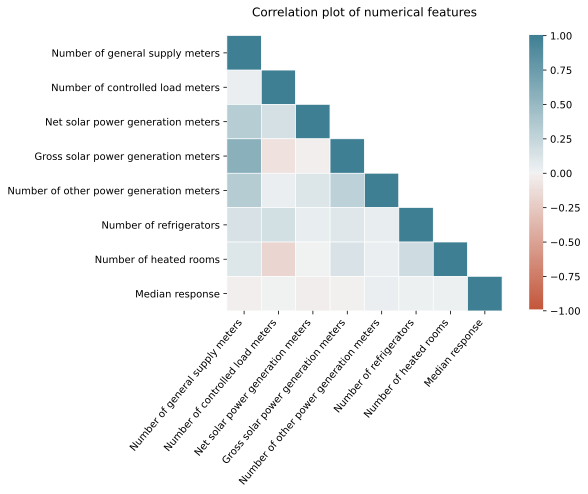

In [10]:
spear_corr = household_response.corr(method="spearman")
pears_corr = household_response.corr()

# Generate a mask for the upper triangle
mask = ~np.tril(np.ones_like(spear_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(spear_corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.6)
plt.title("Correlation plot of numerical features\n")

plt.xticks(rotation=50, ha="right")

axs = plt.gca()
labels = [features_dict[item.get_text()] if item.get_text() in features_dict.keys() else item.get_text() for item in axs.get_yticklabels()]
axs.set_yticklabels(labels)
axs.set_xticklabels(labels)


plt.tight_layout()
plt.show()

We can see that there somewhat high correlation between the `GROSS_SOLAR_CNT` and `GENERAL_SUPPLY_CNT`. And also the **target** variable `median_response` has **low correlation** with the other variables.

For **categorical features** a measure of association is Cramér's V $(\phi_c)$. It gives a value between 0 and +1 (inclusive), and it is based on Pearson's chi-squared statistic $\chi^2$. We can use it only for the nominal features that have 2 categories and more. For more info see [here](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9).

In [11]:
cramers_mask = household_response[nominal_features].nunique() > 1
nominal_features_cramers = cramers_mask[cramers_mask].index.to_list()

# Create the Cramers association matrix
cramer_matrix = pd.DataFrame([[dython.nominal.cramers_v(household_response[col_i], household_response[col_j]) for col_i in nominal_features_cramers] for col_j in nominal_features_cramers],
                 columns=nominal_features_cramers, index=nominal_features_cramers)

We plot a heatmap that shows the strength of the association among categorical variables.

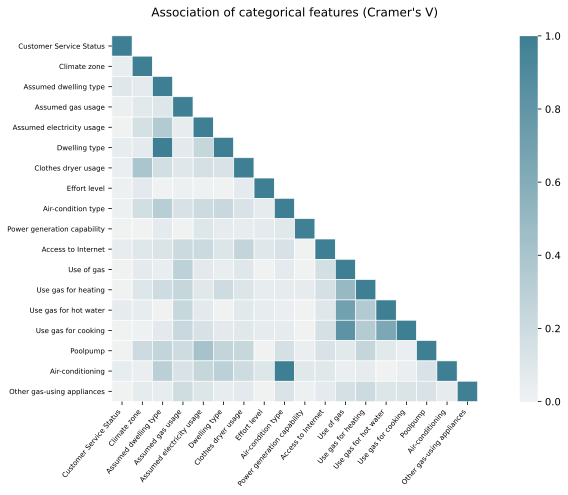

In [12]:
# Generate a mask for the upper triangle
mask = ~np.tril(np.ones_like(cramer_matrix, dtype=bool))

plt.figure(figsize=(12, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
hm = sns.heatmap(cramer_matrix, cmap=cmap, mask=mask, vmin=0, 
            vmax=1, center=0, square=True, linewidths=.6)
plt.title("Association of categorical features (Cramer's V)\n")


labels = [features_dict[item.get_text()] if item.get_text() in features_dict.keys() else item.get_text() for item in hm.get_yticklabels()]

hm.set_yticklabels(labels, size = 7)
hm.set_xticklabels(labels, size = 7)

plt.xticks(rotation=50, ha="right")


plt.tight_layout()
plt.show()

We drop the `ASSRTD_DWELLING_TYPE_CD` because it is strongly associated with `DWELLING_TYPE_CD` (because they are basically the same thing). Also we drop the `AIRCON_TYPE_CD` as it highly associated with the `HAS_AIRCON` feature.

In [13]:
household_response.drop(['ASSRTD_DWELLING_TYPE_CD', 'AIRCON_TYPE_CD', 'HAS_GAS'], axis=1, inplace=True)

In [14]:
household_response.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251 entries, 8922472 to 8629743
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   GENERAL_SUPPLY_CNT             1251 non-null   int64   
 1   CONTROLLED_LOAD_CNT            1251 non-null   int64   
 2   NET_SOLAR_CNT                  1251 non-null   int64   
 3   GROSS_SOLAR_CNT                1251 non-null   int64   
 4   OTHER_LOAD_CNT                 1251 non-null   int64   
 5   SERVICE_LOC_STATUS_NAME        1251 non-null   category
 6   ASSRTD_CLIMATE_ZONE_DESC       1251 non-null   category
 7   ASSRTD_GAS_USAGE_GROUP_CD      1251 non-null   category
 8   ASSRTD_ELECTRICITY_USE_GRP_CD  1251 non-null   category
 9   DWELLING_TYPE_CD               1251 non-null   category
 10  DRYER_USAGE_CD                 1251 non-null   category
 11  REDUCING_CONSUMPTION_CD        1251 non-null   category
 12  NUM_REFRIGERATORS        

We need to reset the features lists excluding the dropped columns.

In [15]:
# Nominal data
nominal_features = household_response.select_dtypes('category').columns.to_list()

# Need to take out the target `median_response` from the list
numeric_features = list(set(numeric_features) - set(['median_response']))

#### Response modelling (regression)
We then go and fit different types of predictive models to see if there is any relationship of the household data and the median response per household. We start by fitting a linear model, and then we try other estimators (e.g. random forest, gradient boosting, NNs). We first split out dataset in train, validation and test set.

In [16]:
X = household_response.drop('median_response', axis=1)
y = household_response['median_response']

# Write predictors' and target's dataset to csv to run multiple models
X.to_csv('data/X_data.csv', index=False)
y.to_csv('data/y_data.csv', index=False)

In [17]:
np.random.seed(seed_value)

# Split data to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create a validation set too
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15) 

# Train: 85%*80% = 68%, Validation: 15%*80% = 12%, Test: 20%

##### Linear regression

In [18]:
# Create the formula R style
all_predictors = "+".join(X_train.columns)
formula = "median_response~" + all_predictors

# Create the model
linear_model = smf.ols(formula=formula, data=X_train.merge(y_train, on='CUSTOMER_KEY'))
res = linear_model.fit()

# Print the summary
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        median_response   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     2.895
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           1.76e-07
Time:                        00:13:20   Log-Likelihood:                -3682.1
No. Observations:                 850   AIC:                             7432.
Df Residuals:                     816   BIC:                             7593.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

We also check for the assumptions of the linear regression to see if they hold, in order to examine whether our results are not biased.

In [19]:
# White’s Lagrange Multiplier Test for Heteroscedasticity
# The null hypothesis for White’s test is that the variances for the errors are equal.
from statsmodels.stats.diagnostic import het_white
white_test = het_white(res.resid,  res.model.exog)

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
pd.DataFrame.from_dict(dict(zip(labels, white_test)), orient='index')

,0
LM Statistic,336.623264
LM-Test p-value,0.556759
F-Statistic,0.976826
F-Test p-value,0.590954


In [20]:
# Jarque-Bera for normality of residuals
# null hypothesis is a joint hypothesis of the skewness being zero and the kurtosis being three (normally distributed)
from statsmodels.stats.stattools import jarque_bera
jb_test = jarque_bera(res.resid, axis=0)

labels = ['JB Statistic', 'JB-Test p-value', 'skew', 'kurtosis']
pd.DataFrame.from_dict(dict(zip(labels, jb_test)), orient='index')

,0
JB Statistic,18.597621
JB-Test p-value,0.000092
skew,0.319546
kurtosis,2.658430


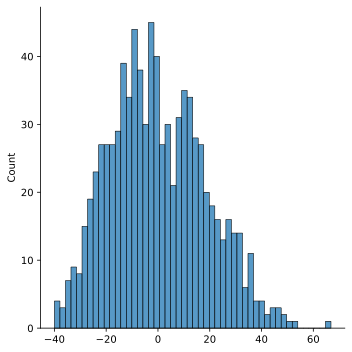

In [21]:
sns.displot(res.resid, bins=50)
plt.show()

The probability of **F-statistic** is quite low, so we can infer that **there is a relationship** between the response and the various features.

The in-sample $R^2$ is quite low, so we that indicates that this model explains a small portion $(\approx 10\%)$ of the variance in the response.

##### All models

We then go and train 4 different models 10 times each in order to get a better idea of their out-of-sample score metrics. The algorithms used are:
* Linear model using OLS
* Random forests
* Gradient boosting on decision trees
* Dense neural networks

We run a script that it trains all the different models and outputs a table with their score metrics on the test set.

In [22]:
%run ../utils/model_run.py "data"

INFO:tensorflow:Reloading Oracle from existing project keras_tuner_output\sgsc\oracle.json
INFO:tensorflow:Reloading Tuner from keras_tuner_output\sgsc\tuner0.json
INFO:tensorflow:Oracle triggered exit
Hyper parameter tuning for NN completed successfully
INFO:tensorflow:Assets written to: keras_saved_model\assets
Saved Keras model



All models have been trained successfully


We then go and calculate the average value of the various error metrics and create a table with the results.

In [23]:
# Read json with results
with open('data/result.json') as json_file:
    data = json.load(json_file)

# Create df with the mean values
mean_df = pd.DataFrame({})
for model in next(iter(data.values())).keys():
    model_list = []
    for iter_value in data.values():
        model_list.append(iter_value[model])
    mean_df[model] = pd.DataFrame(model_list).mean()
    
mean_df

,lm,gbr,rf,dense_nn
RMSE,18.772050,18.700933,19.744463,18.907996
MAE,15.287934,15.248777,16.123537,15.473251
MAPE,0.464776,0.473375,0.483279,0.483952
R2,0.008183,0.015734,-0.110662,-0.008108


In [24]:
# Create df with the standard deviations
std_df = pd.DataFrame({})
for model in next(iter(data.values())).keys():
    model_list = []
    for iter_value in data.values():
        model_list.append(iter_value[model])
    std_df[model] = pd.DataFrame(model_list).std()

std_df

,lm,gbr,rf,dense_nn
RMSE,0.791754,0.767912,1.656483,0.642857
MAE,0.619978,0.647658,1.426165,0.669499
MAPE,0.098549,0.100488,0.101830,0.100940
R2,0.026866,0.021675,0.245974,0.064085


#### Feature importance

We use the linear model which is already trained above. For *random forest*, and *Neural Networks* we use the `sklearn` and `tensorflow` package respectively. As these implementatations cannot handle data internally we need to do some **pre-processing**. For the various categorical encoding see [here](https://contrib.scikit-learn.org/category_encoders/index.html).

In [25]:
# Numerical (no transformation at this point)
X_train_enc = X_train[numeric_features].copy()
X_val_enc = X_val[numeric_features].copy()
X_test_enc = X_test[numeric_features].copy()

# Nominal/Categorical features
enc_cat = CatBoostEncoder(cols=nominal_features)
X_train_enc[nominal_features] = enc_cat.fit_transform(X_train, y_train)[nominal_features].copy()
X_val_enc[nominal_features] = enc_cat.transform(X_val)[nominal_features].copy()
X_test_enc[nominal_features] = enc_cat.transform(X_test)[nominal_features].copy()


##### *Linear model*

In [27]:
# Train linear model
from sklearn.linear_model import LinearRegression
OLS_reg = LinearRegression().fit(X_train_enc, y_train)

##### *Random forest*

In [28]:
# Train the random forest regressor
rfr = RandomForestRegressor()
rfr.fit(X_train_enc, y_train)

RandomForestRegressor()

#### Permutation feature importance

**Permutation feature importance**  measures the increase in the prediction error of the model after permuting the feature's values.  A feature is *important* if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction. In the *x-axis* of the importance graph we have the importance that is the difference between the score metric of the model with the original features, and the model with the permuted (randomly shuffled) feature. So if it is *positive* then that means that permuting the feature decreases the model score and the the feature has predictive power. Whereas if the importance is negative means that permuting the feature gives a better score and therefore the feature should be discarded.

In [29]:
# Calculate the permutation importance for linear regression
perm_lm = permutation_importance(OLS_reg, X_test_enc, y_test, n_repeats=10, n_jobs=2)
sorted_lm = perm_lm.importances_mean.argsort()

# Calculate the permutation importance for random forest
perm_rf = permutation_importance(rfr, X_test_enc, y_test, n_repeats=10, n_jobs=2)
sorted_rf = perm_rf.importances_mean.argsort()

labels_lm_sort = X_test.columns[sorted_lm].to_list()
labels_lm = [features_dict[feature] for feature in labels_lm_sort]

labels_rf_sort = X_test.columns[sorted_rf].to_list()
labels_rf = [features_dict[feature] for feature in labels_rf_sort]

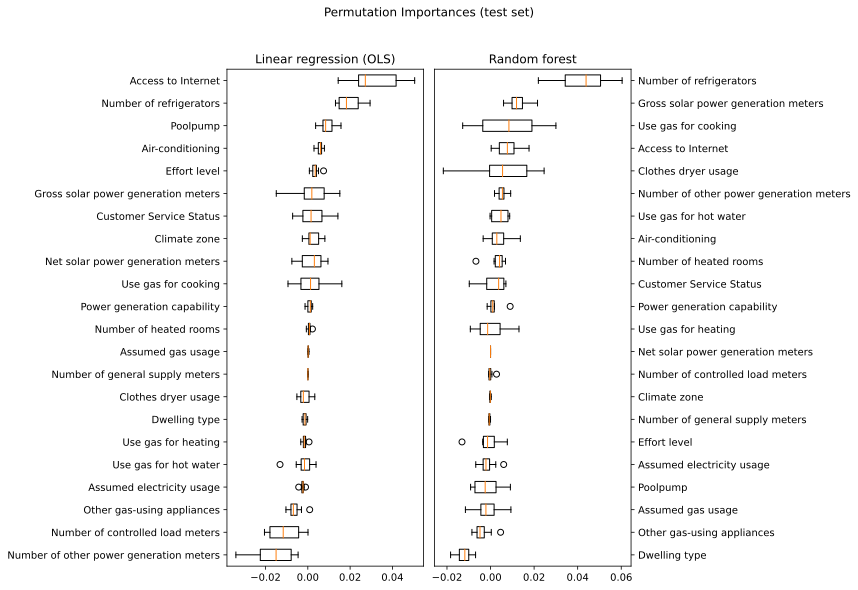

In [30]:
# Plot the permutation importance
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8))

ax1.boxplot(perm_lm.importances[sorted_lm].T,
           vert=False, labels=labels_lm)
ax1.set_title("Linear regression (OLS)")

ax2.boxplot(perm_rf.importances[sorted_rf].T,
           vert=False, labels=labels_rf)
ax2.yaxis.tick_right()
ax2.set_title("Random forest")


fig.suptitle("Permutation Importances (test set)", y=1.02)

fig.tight_layout()
plt.show()

##### SHAP values
We can also use Shapley values to measure feature importance. For more info you can see this [paper](https://www.nature.com/articles/s42256-019-0138-9.epdf?shared_access_token=RCYPTVkiECUmc0CccSMgXtRgN0jAjWel9jnR3ZoTv0O81kV8DqPb2VXSseRmof0Pl8YSOZy4FHz5vMc3xsxcX6uT10EzEoWo7B-nZQAHJJvBYhQJTT1LnJmpsa48nlgUWrMkThFrEIvZstjQ7Xdc5g%3D%3D).

##### *Gradient boosting*

In [31]:
# Define model parameters
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'RMSE',
    'logging_level': 'Silent',
    'use_best_model': True                                        # For choosing the best model based on validation set.
}
# Create pools
train_pool = Pool(X_train, y_train, cat_features=nominal_features)
validate_pool = Pool(X_val, y_val, cat_features=nominal_features)

# Create the model and fit base model
gbr = CatBoostRegressor(**params)
gbr.fit(train_pool, eval_set=validate_pool)

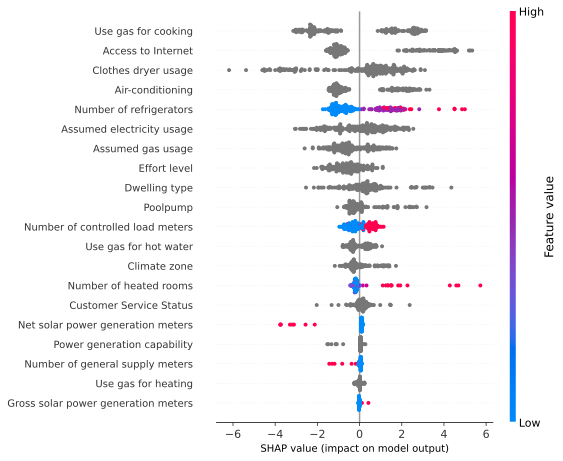

In [32]:
test_pool = Pool(X_test, y_test, cat_features=nominal_features)

# Plot the SHAP values for the Gradient boosting model
shap_values_gbr = gbr.get_feature_importance(test_pool, type='ShapValues')[:,:-1]

shap.summary_plot(shap_values_gbr, X_test, show=False, plot_size=0.25)

axs = plt.gca()
axs.tick_params(axis="y", labelsize=10)
axs.xaxis.label.set_size(10)

y_labels = [features_dict[item.get_text()] if item.get_text() in features_dict.keys() else item.get_text() for item in axs.get_yticklabels()]
axs.set_yticklabels(y_labels)

plt.tight_layout()
plt.show()

We then plot the depedence plots for the eight most significant categorical features.

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


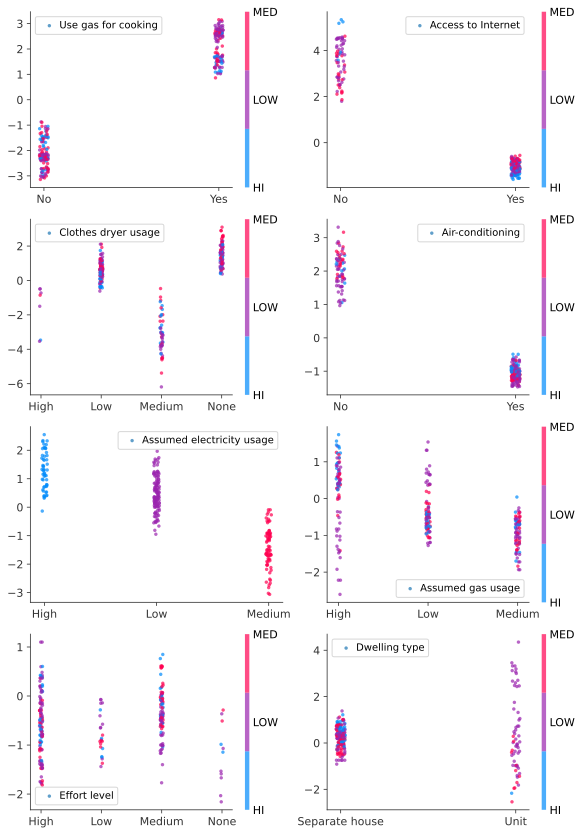

In [33]:
import itertools

nrows = 4
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8.27, 11.69))

# The important features in descending order
import_features_name = X_test.columns[np.argsort(np.abs(shap_values_gbr).mean(0))[::-1]]


# Get the categorical subset
import_cat_name = import_features_name[import_features_name.isin(nominal_features)][:nrows*ncols]


# Get axis index combinations
ax_index_tuples = list(itertools.product(range(nrows), range(ncols)))

for feature, ax_index in zip(import_cat_name, ax_index_tuples):
    shap.dependence_plot(feature, shap_values_gbr, X_test, x_jitter=0.05, 
                         interaction_index='ASSRTD_ELECTRICITY_USE_GRP_CD',
                         alpha=0.7, show=False, dot_size=12,
                         ax=axs[ax_index])  
    
    # Set the xticklabels
    axs[ax_index].xaxis.set_tick_params(rotation=0)
    labels = axs[ax_index].get_xticklabels()
    
    if np.array([item._text != '' for item in labels]).all():
        correct_labels = [labels_dict[item._text] if item._text in labels_dict.keys() else item._text for item in labels ]
        axs[ax_index].set_xticklabels(labels=correct_labels)
    
    # Delete axis titles
    axs[ax_index].set_ylabel('')
    axs[ax_index].set_xlabel('')
    
    # Get colorbar
    cb = plt.gcf().get_children()[-1]
    
    # Remove colorbar legend and make colorbar thinner
    cb.set_ylabel(ylabel='')
    cb.axes.set_aspect(40)
    
    # Add legend
    axs[ax_index].legend([features_dict[feature]], handletextpad=0.0)
    
plt.tight_layout()
plt.show()

The average impact of each feature to the model output is shown below.

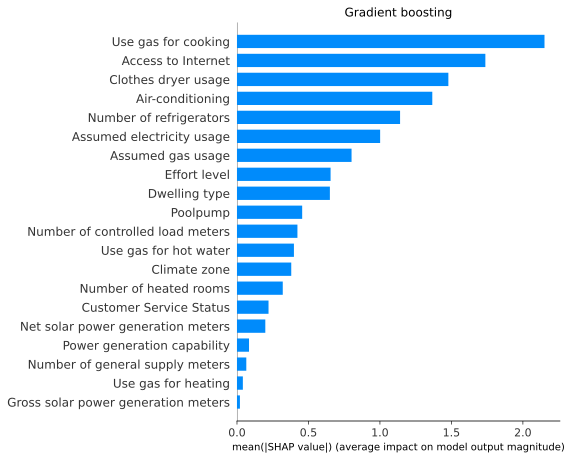

In [34]:
shap.summary_plot(shap_values_gbr, X_test, plot_type="bar", plot_size=0.25, show=False)
fig1 = plt.gcf()
ax1 = plt.gca()
ax1.set_title("Gradient boosting")
ax1.tick_params(axis="y", labelsize=12)
ax1.xaxis.label.set_size(10)

y_labels = [features_dict[item.get_text()] if item.get_text() in features_dict.keys() else item.get_text() for item in ax1.get_yticklabels()]
ax1.set_yticklabels(y_labels)

fig1.tight_layout()
plt.show()

##### *Dense NN*

In [35]:
# Load the Keras model
denseNN = keras.models.load_model('keras_saved_model')

explainer = shap.DeepExplainer(denseNN, X_train_enc.values)
shap_values_NN = explainer.shap_values(X_test_enc.values)

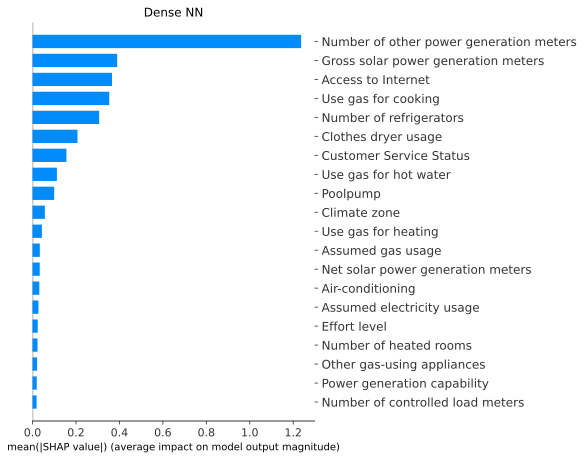

In [36]:
shap.summary_plot(shap_values_NN, X_test, plot_type="bar", plot_size=0.25, show=False)
fig2 = plt.gcf()
ax2 = plt.gca()
ax2.set_title("Dense NN")
ax2.tick_params(axis="y", labelsize=12)
ax2.yaxis.tick_right()
ax2.xaxis.label.set_size(10)
ax2.legend('', frameon=False)

y_labels = [features_dict[item.get_text()] if item.get_text() in features_dict.keys() else item.get_text() for item in ax2.get_yticklabels()]
ax2.set_yticklabels(y_labels)

fig2.tight_layout()
plt.show()

Another way could be to use `Sparce Group Lasso Regularisation`. We could use the `pyglmnet` package. For more info see this [answer](https://stats.stackexchange.com/questions/314567/feature-importance-with-dummy-variables) on Stackexchange, and these papers [[1]](https://www.tse-fr.eu/sites/default/files/TSE/documents/sem2015/statistique/saint_pierre.pdf), [[2]](http://pages.stat.wisc.edu/~myuan/papers/glasso.final.pdf), [[3]](http://people.ee.duke.edu/~lcarin/lukas-sara-peter.pdf).

#### Pool of rankings
We now pool the rankings from the aforementioned feature importance approaches using the ...

In [37]:
# Get ranked results from the the permutation results
rank_lm_perm = pd.DataFrame({'Feature': X_test.columns[sorted_lm], 'rank_lm':reversed(range(1, X_test.columns.shape[0]+1))}).set_index('Feature')

rank_rf_perm = pd.DataFrame({'Feature': X_test.columns[sorted_rf], 'rank_rf':reversed(range(1, X_test.columns.shape[0]+1))}).set_index('Feature')


# Get ranked results from the gradient boosting feature importance importance 
vals_gbr = np.abs(shap_values_gbr).mean(0)
vals_NN = np.abs(shap_values_NN[0]).mean(0)

feature_importance_gbr = pd.DataFrame({'Feature':X_test.columns, 'feature_importance_vals':vals_gbr}).set_index('Feature')
feature_importance_gbr.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
feature_importance_gbr['rank_gbr'] = range(1, feature_importance_gbr.shape[0]+1)
feature_importance_NN = pd.DataFrame({'Feature':X_test.columns, 'feature_importance_vals':vals_NN}).set_index('Feature')
feature_importance_NN.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance_NN['rank_NN'] = range(1, feature_importance_NN.shape[0]+1) 

# Merge all the four df based on the Feature index
from functools import reduce
dfs = [rank_lm_perm, rank_rf_perm, 
       feature_importance_gbr.drop('feature_importance_vals', axis =1), 
       feature_importance_NN.drop('feature_importance_vals', axis =1)]

df_rank = reduce(lambda left,right: pd.merge(left,right,on='Feature'), dfs)

In [38]:
# Use the Markov chain type 4 algorithm for rank aggregation
from mc4.algorithm import mc4_aggregator
aggregated_ranks = mc4_aggregator(df_rank, header_row = 0, index_col = 0) 

final_rank_df = pd.DataFrame.from_dict(aggregated_ranks, orient='index', columns=['aggregated_rank']).sort_values(by='aggregated_rank')
final_rank_df

,aggregated_rank
HAS_INTERNET_ACCESS,1
NUM_REFRIGERATORS,2
HAS_GAS_COOKING,3
GROSS_SOLAR_CNT,4
DRYER_USAGE_CD,5
HAS_AIRCON,6
HAS_POOLPUMP,7
HAS_GAS_HOT_WATER,8
SERVICE_LOC_STATUS_NAME,9
REDUCING_CONSUMPTION_CD,10


---
### Exploration of important features 
We explore if the various levels of important categorical features have any significant impact on the target variable. 

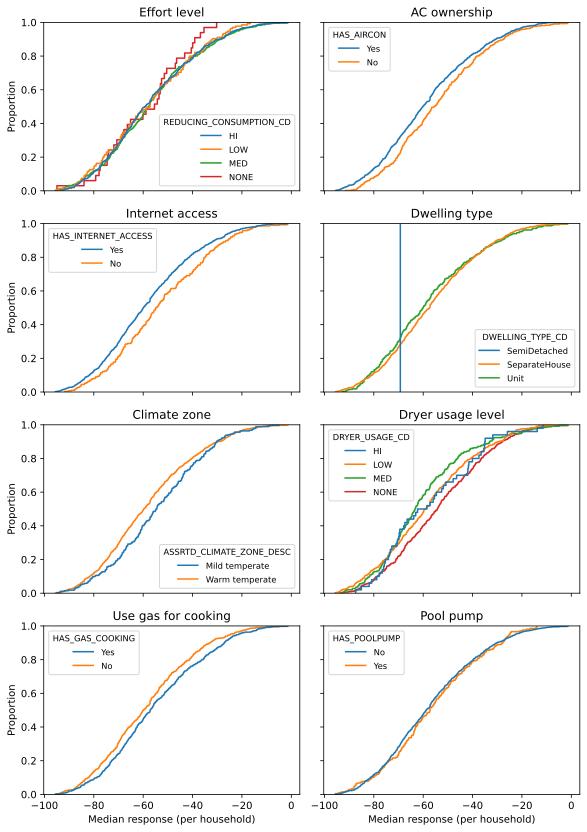

In [39]:
# Convert Y, N to yes and no for easier to read
household_response_plot = household_response.replace({'Y': 'Yes', 'N': 'No'})


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8.27, 11.69), sharex=True, sharey=True)


# Effort level plot
sns.ecdfplot(data=household_response_plot, x="median_response", 
                       hue="REDUCING_CONSUMPTION_CD", ax=axs[0, 0])
axs[0, 0].set_title('Effort level')
plt.setp(axs[0, 0].get_legend().get_texts(), fontsize='small')
plt.setp(axs[0, 0].get_legend().get_title(), fontsize='small')

# AC plot
sns.ecdfplot(data=household_response_plot, x="median_response", 
                       hue="HAS_AIRCON", ax=axs[0, 1])
axs[0, 1].set_title('AC ownership')
plt.setp(axs[0, 1].get_legend().get_texts(), fontsize='small')
plt.setp(axs[0, 1].get_legend().get_title(), fontsize='small')

sns.ecdfplot(data=household_response_plot, x="median_response", 
             hue="HAS_INTERNET_ACCESS", ax=axs[1, 0])
axs[1, 0].set_title('Internet access')
plt.setp(axs[1, 0].get_legend().get_texts(), fontsize='small')
plt.setp(axs[1, 0].get_legend().get_title(), fontsize='small')

sns.ecdfplot(data=household_response_plot, x="median_response", 
             hue="DWELLING_TYPE_CD", ax=axs[1, 1])
axs[1, 1].set_title('Dwelling type')
plt.setp(axs[1, 1].get_legend().get_texts(), fontsize='small')
plt.setp(axs[1, 1].get_legend().get_title(), fontsize='small')

sns.ecdfplot(data=household_response_plot, x="median_response", 
             hue="ASSRTD_CLIMATE_ZONE_DESC", ax=axs[2, 0])
axs[2, 0].set_title('Climate zone')
plt.setp(axs[2, 0].get_legend().get_texts(), fontsize='small')
plt.setp(axs[2, 0].get_legend().get_title(), fontsize='small')

sns.ecdfplot(data=household_response_plot, x="median_response", 
             hue="DRYER_USAGE_CD", ax=axs[2, 1])
axs[2, 1].set_title('Dryer usage level')
plt.setp(axs[2, 1].get_legend().get_texts(), fontsize='small')
plt.setp(axs[2, 1].get_legend().get_title(), fontsize='small')

sns.ecdfplot(data=household_response_plot, x="median_response", 
             hue="HAS_GAS_COOKING", ax=axs[3, 0])
axs[3, 0].set(xlabel='Median response (per household)')
axs[3, 0].set_title('Use gas for cooking')
plt.setp(axs[3, 0].get_legend().get_texts(), fontsize='small')
plt.setp(axs[3, 0].get_legend().get_title(), fontsize='small')

sns.ecdfplot(data=household_response_plot, x="median_response", 
             hue="HAS_POOLPUMP", ax=axs[3, 1])
axs[3, 1].set(xlabel='Median response (per household)')
axs[3, 1].set_title('Pool pump')
plt.setp(axs[3, 1].get_legend().get_texts(), fontsize='small')
plt.setp(axs[3, 1].get_legend().get_title(), fontsize='small')


plt.tight_layout()
plt.show()